# 02 - Feature Engineering

**Objectif** : Créer de nouvelles variables (features) pour améliorer le modèle.

---

## Questions à se poser :
1. Quelles informations temporelles peut-on extraire de la date ?
2. Y a-t-il des features Landsat qu'on n'utilise pas encore ?
3. Peut-on créer des combinaisons de features (ratios, produits) ?
4. Les nouvelles features sont-elles corrélées avec les targets ?

---

## Programme du notebook :
1. Charger les données
2. Créer des features temporelles (mois, saison)
3. Explorer les autres features Landsat disponibles
4. Créer de nouveaux indices spectraux (ratios)
5. Vérifier si les nouvelles features sont utiles
6. Créer une fonction réutilisable

---
## 1. Imports et chargement

In [1]:
# Imports de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration des graphiques
plt.rcParams['figure.figsize'] = (10, 6)

# Pour ignorer les warnings
import warnings
warnings.filterwarnings('ignore')

# Accéder au dossier src/
import sys
sys.path.append('..')

from src.paths import WATER_QUALITY_FILE, LANDSAT_FILE, TERRACLIMATE_FILE
from src.data.load_data import load_all
from src.config import TARGETS, BENCHMARK_FEATURES, LANDSAT_FEATURES

print("Imports OK!")

Imports OK!


In [2]:
# Charger les données
X, y, site_ids, df = load_all(
    str(WATER_QUALITY_FILE),
    str(LANDSAT_FILE),
    str(TERRACLIMATE_FILE)
)

CHARGEMENT DES DONNÉES
[OK] Water quality: 9319 lignes
[OK] Landsat: 9319 lignes
[OK] TerraClimate: 9319 lignes
[OK] Données fusionnées: 9319 lignes, 13 colonnes

Valeurs manquantes:

6 colonnes avec des valeurs manquantes:
  - nir: 1085 manquants (11.6%)
  - green: 1085 manquants (11.6%)
  - swir16: 1085 manquants (11.6%)
  - swir22: 1085 manquants (11.6%)
  - NDMI: 1085 manquants (11.6%)
  - MNDWI: 1085 manquants (11.6%)
[OK] 162 sites uniques identifiés
[OK] X: 9319 lignes, 4 features
[OK] y: 9319 lignes, 3 targets

PRÊT!


<cell_type>markdown</cell_type>---
## 2. Features temporelles

**Pourquoi ?** La qualité de l'eau varie selon les saisons (pluie, température, etc.)

**Features retenues :**
- `day_of_year` : position dans l'année (1-365), capture la saisonnalité fine
- `season` : saison (4 catégories), plus simple pour le modèle

**Features écartées :**
- `year` : risque d'overfitting (seulement 5 ans de données)
- `month` : redondant avec `day_of_year`

In [3]:
# Extraire le jour de l'année (1-365)
df['day_of_year'] = df['Sample Date'].dt.dayofyear

print("Feature 'day_of_year' créée!")
print(f"  - Min: {df['day_of_year'].min()}")
print(f"  - Max: {df['day_of_year'].max()}")
df[['Sample Date', 'day_of_year']].head()

Feature 'day_of_year' créée!
  - Min: 1
  - Max: 365


,Sample Date,day_of_year
0,2011-01-02,2
1,2011-01-03,3
2,2011-01-03,3
3,2011-01-03,3
4,2011-01-03,3


In [4]:
# Créer une variable "saison"
# Note: Afrique du Sud = hémisphère sud (saisons inversées par rapport à l'Europe)

def get_season(date):
    """Retourne la saison pour une date (hémisphère sud)."""
    month = date.month
    if month in [12, 1, 2]:
        return 'summer'  # Été austral (décembre-février)
    elif month in [3, 4, 5]:
        return 'autumn'  # Automne (mars-mai)
    elif month in [6, 7, 8]:
        return 'winter'  # Hiver (juin-août)
    else:
        return 'spring'  # Printemps (septembre-novembre)

df['season'] = df['Sample Date'].apply(get_season)

print("Feature 'season' créée!")
print("\nRépartition par saison :")
print(df['season'].value_counts())

Feature 'season' créée!

Répartition par saison :
season
spring    2474
winter    2438
autumn    2406
summer    2001
Name: count, dtype: int64


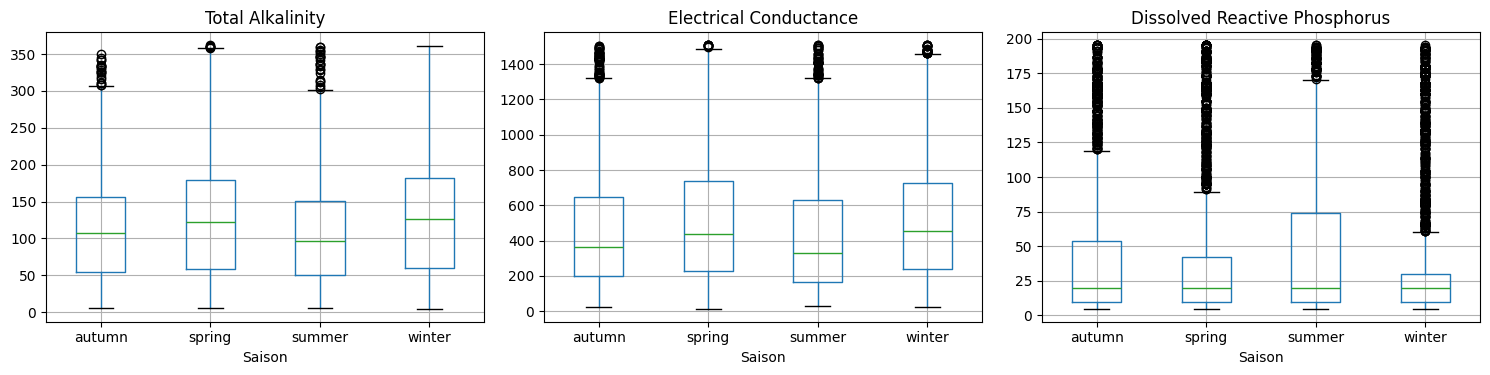

In [5]:
# Visualiser l'effet de la saison sur les targets
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, target in enumerate(TARGETS):
    ax = axes[i]
    df.boxplot(column=target, by='season', ax=ax)
    ax.set_title(target)
    ax.set_xlabel('Saison')

plt.suptitle('')  # Enlever le titre automatique
plt.tight_layout()
plt.show()

---
## 3. Utiliser plus de features Landsat

Le benchmark n'utilise que `swir22`, `NDMI`, `MNDWI`. Il y a d'autres bandes disponibles!

In [6]:
# Quelles features Landsat sont disponibles ?
print("Features Landsat disponibles :")
for f in LANDSAT_FEATURES:
    if f in df.columns:
        print(f"  - {f} : OK")
    else:
        print(f"  - {f} : MANQUANTE")

Features Landsat disponibles :
  - nir : OK
  - green : OK
  - swir16 : OK
  - swir22 : OK
  - NDMI : OK
  - MNDWI : OK


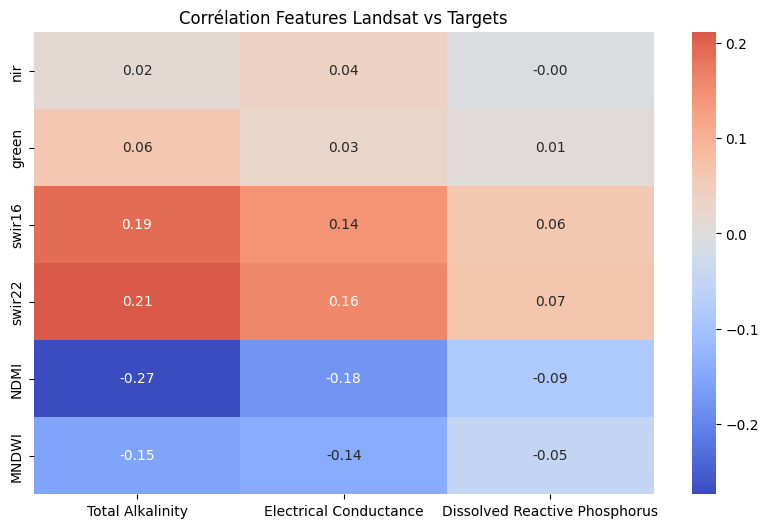

In [7]:
# Corrélation des features Landsat avec les targets
landsat_in_df = [f for f in LANDSAT_FEATURES if f in df.columns]

corr = df[landsat_in_df + TARGETS].corr()
corr_subset = corr.loc[landsat_in_df, TARGETS]

plt.figure(figsize=(10, 6))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Corrélation Features Landsat vs Targets')
plt.show()

---
## 4. Créer de nouveaux indices spectraux

Les indices spectraux sont des combinaisons de bandes qui ont une signification physique.

In [8]:
# Exemple : ratio entre bandes
# Ces ratios peuvent capturer des informations sur la turbidité, la chlorophylle, etc.

if 'nir' in df.columns and 'green' in df.columns:
    # Ratio NIR/Green (sensible à la végétation/algues)
    df['nir_green_ratio'] = df['nir'] / (df['green'] + 0.0001)  # +0.0001 pour éviter division par 0
    print("Feature 'nir_green_ratio' créée!")

if 'swir16' in df.columns and 'swir22' in df.columns:
    # Ratio entre les deux SWIR
    df['swir_ratio'] = df['swir16'] / (df['swir22'] + 0.0001)
    print("Feature 'swir_ratio' créée!")

Feature 'nir_green_ratio' créée!
Feature 'swir_ratio' créée!


---
## 5. Résumé des features créées

In [9]:
# Liste des nouvelles features
new_features = ['day_of_year', 'season']

if 'nir_green_ratio' in df.columns:
    new_features.append('nir_green_ratio')
if 'swir_ratio' in df.columns:
    new_features.append('swir_ratio')

print("Nouvelles features créées :")
for f in new_features:
    print(f"  - {f}")

Nouvelles features créées :
  - day_of_year
  - season
  - nir_green_ratio
  - swir_ratio


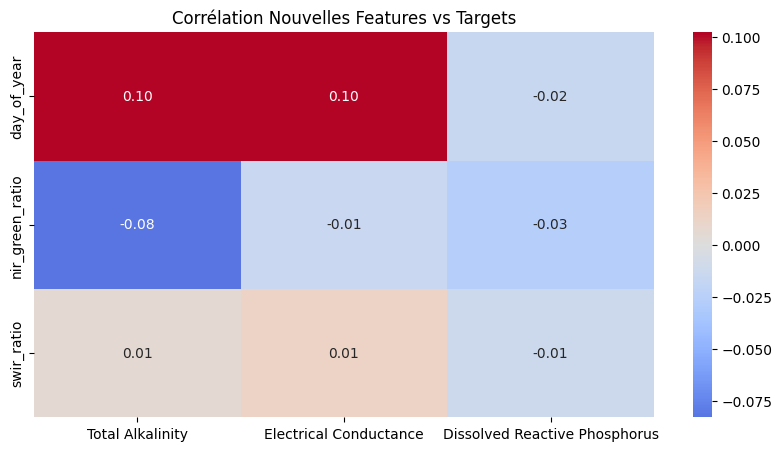

In [10]:
# Tester la corrélation des nouvelles features numériques avec les targets
numeric_new_features = ['day_of_year']

if 'nir_green_ratio' in df.columns:
    numeric_new_features.append('nir_green_ratio')
if 'swir_ratio' in df.columns:
    numeric_new_features.append('swir_ratio')

if numeric_new_features:
    corr = df[numeric_new_features + TARGETS].corr()
    corr_subset = corr.loc[numeric_new_features, TARGETS]
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(corr_subset, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Corrélation Nouvelles Features vs Targets')
    plt.show()

---
## 6. Fonction pour créer toutes les features

On regroupe tout dans une fonction réutilisable.

In [11]:
def create_features(df):
    """
    Crée toutes les features supplémentaires.
    
    Features temporelles :
    - day_of_year : jour de l'année (1-365)
    - season : saison (summer, autumn, winter, spring)
    
    Features spectrales :
    - nir_green_ratio : ratio NIR/Green
    - swir_ratio : ratio SWIR16/SWIR22
    
    Paramètres:
        df : DataFrame avec les données brutes
    
    Retourne:
        DataFrame avec les nouvelles features
    """
    df = df.copy()
    
    # Features temporelles
    if 'Sample Date' in df.columns:
        # Jour de l'année (1-365)
        df['day_of_year'] = df['Sample Date'].dt.dayofyear
        
        # Saison (hémisphère sud)
        def get_season(date):
            month = date.month
            if month in [12, 1, 2]: return 'summer'
            elif month in [3, 4, 5]: return 'autumn'
            elif month in [6, 7, 8]: return 'winter'
            else: return 'spring'
        
        df['season'] = df['Sample Date'].apply(get_season)
    
    # Ratios spectraux
    if 'nir' in df.columns and 'green' in df.columns:
        df['nir_green_ratio'] = df['nir'] / (df['green'] + 0.0001)
    
    if 'swir16' in df.columns and 'swir22' in df.columns:
        df['swir_ratio'] = df['swir16'] / (df['swir22'] + 0.0001)
    
    return df

print("Fonction create_features() définie!")
print("\nFeatures créées par cette fonction :")
print("  - day_of_year (temporelle)")
print("  - season (temporelle)")
print("  - nir_green_ratio (spectrale)")
print("  - swir_ratio (spectrale)")

Fonction create_features() définie!

Features créées par cette fonction :
  - day_of_year (temporelle)
  - season (temporelle)
  - nir_green_ratio (spectrale)
  - swir_ratio (spectrale)


<cell_type>markdown</cell_type>---
## 7. Prochaine étape

### Récapitulatif des features créées :

| Feature | Type | Description |
|---------|------|-------------|
| `day_of_year` | Temporelle | Jour de l'année (1-365) |
| `season` | Temporelle | Saison (summer, autumn, winter, spring) |
| `nir_green_ratio` | Spectrale | Ratio NIR/Green (végétation/algues) |
| `swir_ratio` | Spectrale | Ratio SWIR16/SWIR22 |

### Idées pour aller plus loin :
- Ajouter d'autres variables TerraClimate (température, précipitations...)
- Encoder `day_of_year` en sin/cos (encodage cyclique)
- Créer des features d'interaction (produits de features)

→ **Notebook 03 : Modélisation**